# Proof of concept for pairplot_with_gmm()

### imports

In [1]:
import graspologic 
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from graspologic.simulations import sbm
from sklearn.utils import check_X_y
from graspologic.embed import AdjacencySpectralEmbed
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [2]:
import seaborn as sns
sns.__version__

'0.11.0'

In [3]:
n_communities = [50, 50, 50]
p = [[0.5, 0.1, 0.05],
     [0.1, 0.4, 0.15],
     [0.05, 0.15, 0.3],]

np.random.seed(2)
A = sbm(n_communities, p)
ase = AdjacencySpectralEmbed()
X = ase.fit_transform(A)

In [69]:
def _plot_ellipse_and_data(
    data, X, j, k, means, covariances, ax, label_palette, cluster_palette, alpha
):
    r"""
    plot_ellipse makes a scatter plot from the two dimensions j,k where j
    corresponds to x-axis
    and k corresponds to the y-axis onto the axis that is ax. plot_ellipse then
    applies a gmm ellipse onto the scatterplot
    using the data from Y_(which is stored in data["clusters"]),
    means, covariances.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data.
    j : int
        column index of feature of interest from X which will be the x-axis data.
    k : int
        column index of feature of interest from X which will be the y-axis data.
    means : array-like, shape (n_components, n_features)
        Estimated means from gmm
    covariances : array-like, shape (with 'full') (n_components, n_features, n_features)
        estimated covariances from gmm
    ax : axis object
        The location where plot_ellipse will plot
    label_palette : dict, optional, default: dictionary using 'Set1'
    cluster_palette : dict, optional, default: dictionary using 'Set1'
    alpha : float, optional, default: 0.7
        Opacity value of plotter markers between 0 and 1

    References
    ----------
    .. [1]  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py.
    """
    sns.scatterplot(
        data=data, x=X[:, j], y=X[:, k], ax=ax, hue="labels", palette=label_palette
    )
    for i, (mean, covar) in enumerate(zip(means, covariances)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(
            [mean[j], mean[k]],
            v[0],
            v[1],
            180.0 + angle,
            color=cluster_palette[i],
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha)
        ax.add_artist(ell)
        # removes tick marks from off diagonal graphs
        ax.set(xticks=[], yticks=[], xlabel=k, ylabel=k)
        ax.legend().remove()


def pairplot_with_gmm(
    X,
    gmm,
    labels=None,
    cluster_palette="Set1",
    label_palette="Set1",
    title=None,
    context="talk",
    font_scale=1,
    alpha=0.7,
    figsize=(12, 12),
    kde=True,
):
    r"""
    Plot pairwise relationships in a dataset.
    By default, this function will create a grid of Axes such that each
    dimension in data will by shared in the y-axis across a single row and
    in the x-axis across a single column.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data.
    gmm: GaussianMixture object
    labels : array-like or list, shape (n_samples), optional
        Labels that correspond to each sample in X.
        If labels are not passed in then labels assume the same value as
        the gmm clusters each point as
    label_palette : str or dict, optional,
        default : dictionary using 'Set1'
    cluster_palette : str or dict, optional, default: dictionary using 'Set1'
        default : dictionary using 'Set1'
    title : string, no default
    context :  None, or one of {talk (default), paper, notebook, poster}
        Seaborn plotting context
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    alpha : float, optional, default: 0.7
        Opacity value of plotter markers between 0 and 1
    figsize : tuple
        the size of the 2d subplots configuration
    kde : boolean
        allows for access of KDE argument in histplot
    """
    # Handle X and labels
    if labels is not None:
        check_X_y(X, labels)
    # Handle gmm
    if gmm is None:
        msg = "You must input a sklearn.mixture.GaussianMixture"
        raise NameError(msg)
    Y_, means, covariances = gmm.predict(X), gmm.means_, gmm.covariances_
    data = pd.DataFrame(data=X)
    n_components = gmm.n_components
    # setting up the data DataFrame
    if labels is None:
        lab_names = [i for i in range(n_components)]
        data["labels"] = np.asarray([lab_names[Y_[i]] for i in range(Y_.shape[0])])
    else:
        data["labels"] = labels
    data["clusters"] = Y_
    # labels are given we must check whether input is correct
    if labels is not None:
        if isinstance(label_palette, str):
            colors = sns.color_palette(label_palette, n_components)
            label_palette = dict(zip(np.unique(np.asarray(labels)), colors))
        elif not isinstance(label_palette, dict):
            msg = "When giving labels must supply palette in string or dictionary"
            raise ValueError(msg)
        if isinstance(cluster_palette, str):
            colors = sns.color_palette(cluster_palette, n_components)
            cluster_palette = dict(zip(np.unique(Y_), colors))
        elif not isinstance(label_palette, dict):
            msg = "When giving labels must supply palette in string or dictionary"
            raise ValueError(msg)
    else:
        # no labels given we go to default.
        colors = sns.color_palette(cluster_palette, n_components)
        labels = np.unique(Y_)
        cluster_palette = dict(zip(np.unique(labels), colors))
        label_palette = dict(zip(np.unique(np.asarray(labels)), colors))

    with sns.plotting_context(context=context, font_scale=font_scale):
        dimensions = X.shape[1]
        # we only want 1 scatter plot for 2 features
        if X.shape[1] == 2:
            dimensions = 1
        pairplot, axes = plt.subplots(
            dimensions, dimensions, figsize=figsize, squeeze = False
        )
        # this will allow for uniform iteration whether axes was 2d or 1d
        axes = axes.flatten()
        for i in range(dimensions):
            for j in range(dimensions):
                if i == j and X.shape[1] > 2:
                    # take care of the distplot on diagonal
                    for t, lab in zip([i for i in range(X.shape[1])], label_palette):
                        sns.distplot(
                            X[Y_ == t, i],
                            kde=kde,
                            ax=axes[dimensions * i + j],
                            color=label_palette[lab],
                        )
                    # this removes the tick marks from the histplot
                    axes[dimensions * i + j].set_xticks([])
                    axes[dimensions * i + j].set_yticks([])
                else:
                    # take care off off-diagonal scatterplots
                    ax1, ax2 = j, i
                    # with only a scatter plot we must make sure we plot
                    # the first and second feature of X
                    if X.shape[1] == 2:
                        ax1, ax2 = 0, 1
                    _plot_ellipse_and_data(
                        data,
                        X,
                        ax1,
                        ax2,
                        means,
                        covariances,
                        axes[dimensions * i + j],
                        label_palette,
                        cluster_palette,
                        alpha=alpha,
                    )
        # formatting
        if title:
            pairplot.suptitle(title)
        for i in range(dimensions):
            for j in range(dimensions):
                if X.shape[1] == 2:
                    axes[dimensions * i + j].set_ylabel("Dimension " + str(1))
                    axes[dimensions * i + j].set_xlabel("Dimension " + str(2))
                else:
                    axes[dimensions * i + j].set_ylabel("Dimension " + str(i+1))
                    axes[dimensions * i + j].set_xlabel("Dimension " + str(j+1))

        for ax in axes.flat:
            ax.label_outer()
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
        # set up the legend correctly by only getting handles(colored dot)
        # and label corresponding to unique pairs
        if X.shape[1] == 2:
            handles, labels = axes[0].get_legend_handles_labels()
        else:
            handles, labels = axes[1].get_legend_handles_labels()
        pairplot.legend(
            handles,
            labels,
            loc="center right",
        )
        return pairplot

Default case with 2 dimensions

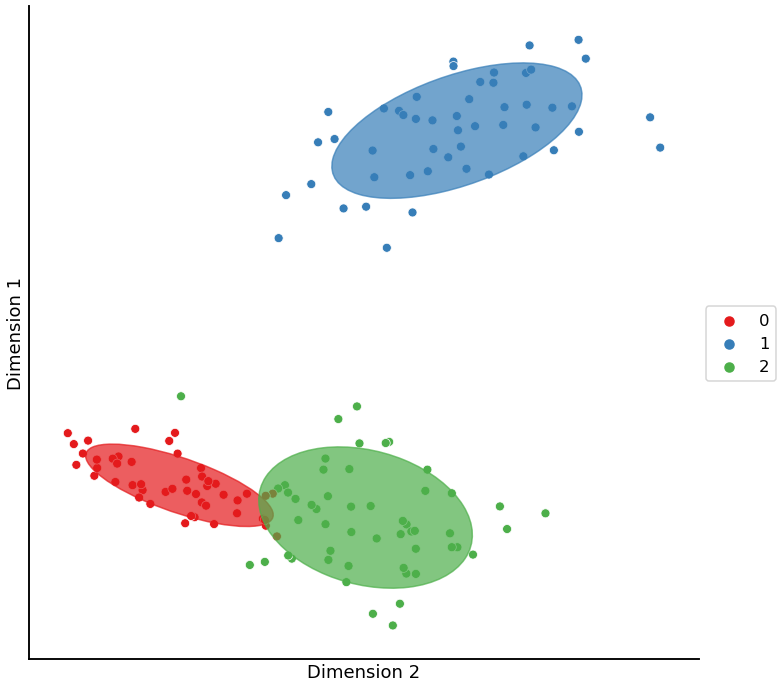

In [70]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X[:, :2])
graph = pairplot_with_gmm(X[:, :2], gmm, labels = None)

Case with 2 dimensions and given palettes and labels

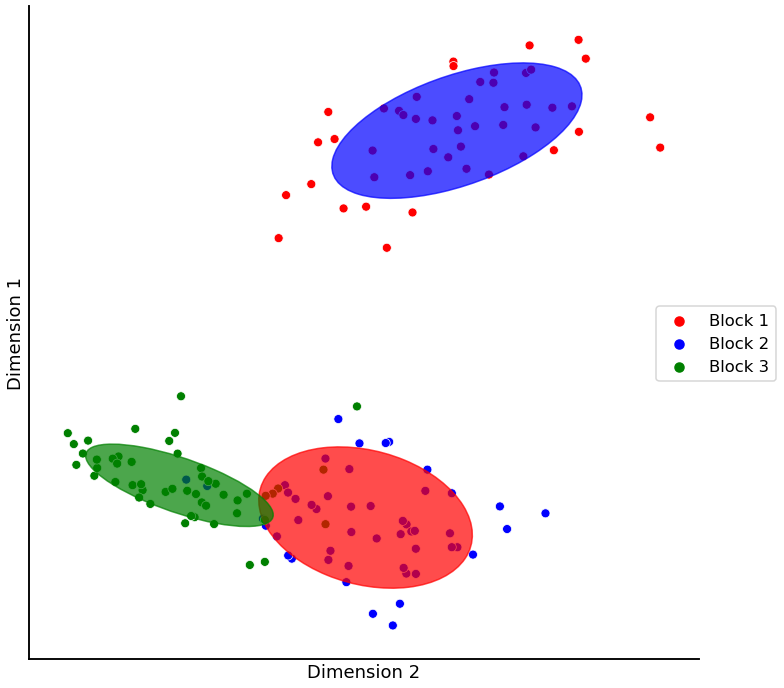

In [71]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X[:, :2])

labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
cluster_palette = {0: 'red', 1:'blue', 2: 'green'}
label_palette = {"Block 1": 'red', 'Block 2':'blue', 'Block 3': 'green'}
graph = pairplot_with_gmm(X[:, :2], gmm, labels = labels, cluster_palette = cluster_palette,  label_palette = label_palette)

Case with default and larger than 2 dimensions

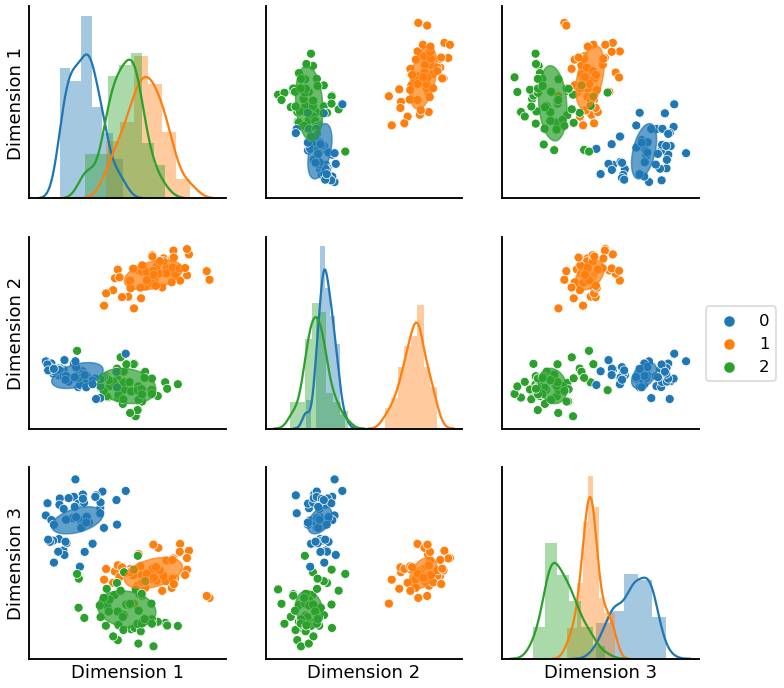

In [72]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X)

labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
cluster_palette = {0: 'red', 1:'blue', 2: 'green'}
label_palette = {"Block 1": 'red', 'Block 2':'blue', 'Block 3': 'green'}
#pairplot_with_gmm(X, gmm, labels = labels, cluster_palette = cluster_palette,  label_palette = label_palette)
graph = pairplot_with_gmm(X, gmm, labels = None, cluster_palette = None,  label_palette = None)

Case with larger than two dimensions with given palettes and labels

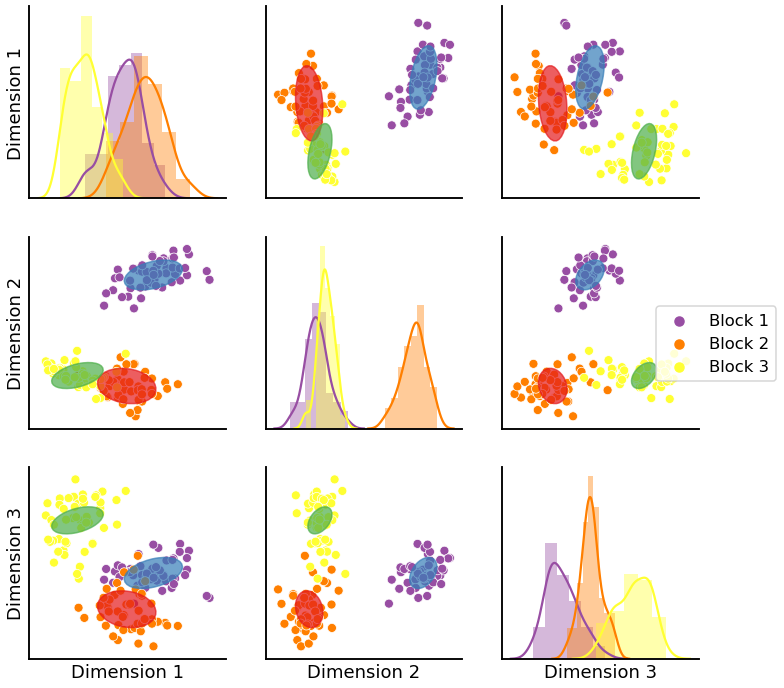

In [73]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X)

labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
#we need 2*n_components to get two differnt colors for labels and clusters but from same palette
color = sns.color_palette("Set1", 2*3)
cluster_palette = {0: color[0], 1:color[1], 2: color[2]}
label_palette = {"Block 1": color[3], 'Block 2':color[4], 'Block 3': color[5]}
graph = pairplot_with_gmm(X, gmm, labels = labels, cluster_palette = cluster_palette,  label_palette = label_palette)


## some checks Ben wanted to see

In [74]:
check_X_y(X, labels)

(array([[ 0.64276071,  0.41009511,  0.2119385 ],
        [ 0.58851067,  0.56997606, -0.00536776],
        [ 0.50241447,  0.49118651, -0.07707138],
        [ 0.50632949,  0.48256433,  0.14144791],
        [ 0.51461323,  0.28210415, -0.09799432],
        [ 0.52848854,  0.3668495 , -0.09188105],
        [ 0.67170034,  0.59853196,  0.16468953],
        [ 0.55167559,  0.59250627,  0.02872629],
        [ 0.49131661,  0.2094466 , -0.20091641],
        [ 0.42283623,  0.34042576, -0.05681181],
        [ 0.59800471,  0.49875205,  0.0973586 ],
        [ 0.55846617,  0.41762358,  0.00617375],
        [ 0.59688805,  0.46217246, -0.04682903],
        [ 0.5660349 ,  0.51519412, -0.04194076],
        [ 0.58797897,  0.54895834, -0.00897595],
        [ 0.47999339,  0.35461043,  0.03919201],
        [ 0.62617581,  0.45708546, -0.02740286],
        [ 0.66516359,  0.63726503,  0.11412216],
        [ 0.66549205,  0.44806536,  0.03357283],
        [ 0.51766392,  0.47458428, -0.00381417],
        [ 0.42899042

In [75]:
check_X_y(X, "test")

ValueError: y should be a 1d array, got an array of shape () instead.

In [76]:
check_X_y(X)

TypeError: check_X_y() missing 1 required positional argument: 'y'